## ASTR 502 Final Project: Applications of Convolutional Neural Networks (CNN's)
### Timothy Purdy - Spring 2020

# Summary:

This project report is a follow-up to a presentation given in April 2020 on Deep Learning and Neural Networks. The example Convolutional Neural Network (CNN) from AstroML web site, is a non-functioning version, mostly due to changes in various libraries used as well as missing data files. Much effort has been made to correct these issues and a revised version is presented below. The original AstroML version is a version based upon, and revised, from the Nair and Abraham github site (https://github.com/mhuertascompany/IAC_XXX_WINTER.git). For my Solar Feature Detection project, and given the complexities of the presented CNN, a more mundane approach of image analysis would yield faster and easier to implement methods of Classification.


### Outline:
1. Will first go thru some steps showing how the AstroML CNN example program was "bootstrapped" for data and modified showing expected results.

2. A review of final project, Solar Feature Detection, and the creation of cropped fits images for CNN Image Input.  

# Obtain the SDSS Images:


In order to fully utilize the AstroML CNN example, we need to "bootstrap" from the data created by Nair and Abraham:

- Download the SDSS data set (a tar'ed gzip file) from: https://drive.google.com/drive/folders/1ufj6ATroZ3emBbSQfQhcL_6W87EPgTaS
- Obtain a copy of Fits file: https://github.com/mhuertascompany/IAC_XXX_WINTER/tree/master/morphology/Nair_Abraham_cat.fit
  - Optionally: git clone https://github.com/mhuertascompany/IAC_XXX_WINTER.git

### Function to Read the SDSS Images:
The following library initialization and function declarations are used for creating the data sets needed for AsroML CNN example code.

In [1]:
# Import libraries needed for reading files:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib.pyplot import imread
from scipy.ndimage import zoom
import imageio
import os

In [15]:
# to cut stamps -- ignore
def extract_thumb(im,x,y,size):
    if size %2==0:
        size = size+1
    up_x=int(x-size/2)
    dow_x=int(x+size/2)
    up_y=int(y-size/2)
    dow_y=int(y+size/2)
    res=im[up_x:dow_x,up_y:dow_y]        
    return res 

# this function only reads jpeg images and saves them to a numpy array. images are rebnned to a 69*68 pixel size to 
# speed computation in the CNN part.
# not very "clean" -- sorry
def read_data(pathsave,maxim):
    
    # image size that will go into the network (this is only for the deep learning part, not the RF)
    size_im=69
    size_crop=207
  

    data=fits.getdata(pathsave+'Nair_Abraham_cat.fit',1)
    idcat=data['dr7objid']
    ttype=data['TType']
    
    #define the morphologies we want to retrieve
    m=ttype*0-1
    # this should select elliptical galaxies(visually classified)
    m[np.where((ttype>=-5) & (ttype<=0))]=0
    # this should select spiral galaxies (visually classified)
    m[np.where((ttype>0) & (ttype<=10))]=1
      
    D=np.zeros([maxim,size_im,size_im,3])  #input tensor - images dimensions + color channels
    Y=np.zeros(maxim) #label vector
    idvec=np.zeros([maxim], dtype=np.int64)
    
    iteri=-1;
    numim=0;
    numim_init=numim
    nplace=0  #location 1st galaxy to be read 
    catalog=Table(data)

    while iteri<maxim-1:
        if iteri>=-1:
            numgal=idcat[numim]
            namegal=str(numgal)+"_GZOO_.jpg"        
            scidata = imread(pathsave+'cutouts_jpeg_all/'+namegal)
            f=numim
            
            print('reading: '+namegal)
            
        if iteri<-1:
            print("Galaxy number %d is missing" % (numim))
            print(namegal)
            numim += 1
            continue
        
        lx,ly, lz=scidata.shape
        #wrong shape - ignore image
        if lx < 256 or ly<256 or m[f]<0:
            numim += 1
            continue

        if lx<size_im:
            numim += 1
            continue

        
        scidata = extract_thumb(scidata,int(lx/2.0),int(ly/2.0),size_crop) # take only a cutout of 207*207 pixels
        scidata=zoom(scidata, [1/3.,1./3,1], order=3)  #keep 1/3 pixels to speed up
        
        
        iteri=iteri+1
        
        
        D[iteri,:,:,:]=scidata  #add image to the input tensor

        Y[iteri]=m[numim] #update the label
        
        idvec[iteri]=idcat[numim] 

        if (m[numim]==0 and iteri%100 ==0):
            print("Saving example")
            examplesDir = pathsave+"example_stamps/"
            try:
                os.mkdir(examplesDir)
            except OSError:
                print ("Creation of the directory: \"%s\", already exists." % examplesDir)
            else:
                print ("Successfully created the directory: \"%s\"" % examplesDir)
            imageio.imwrite(pathsave+"example_stamps/"+namegal,scidata)
            
         
        numim=numim+1

        
        Y = Y.squeeze()

    # this is to avoid reading all images at every training
    print("Saving image, target, and ID vectors...")
    np.save(pathsave+"image_vector_Sab_"+str(maxim)+".npy",D) 
    np.save(pathsave+"target_vector_Sab_"+str(maxim)+".npy",Y)
    np.save(pathsave+"ID_vector_Sab_"+str(maxim)+".npy",idvec)
    
    # create and save versions of the data files needed by AstroML
    print("Saving AstroML version files...")
    np.save(pathsave+"sdss_images_"+str(maxim)+".npy",D) 
    np.save(pathsave+"sdss_labels_"+str(maxim)+".npy",Y)
    

    return D,Y

# D contains the images
# Y the labels to be learned (morphology, i.e. y=0-->elliptical, y=1-->spiral)

### Read and Create Preliminary Files:

The following code snippet (from Nair and Abraham) will read the Fits catalog file to process against the correspondingly named SDSS Jpeg images.

In [16]:
# NOTE: uncomment the following variables to do a "bootstrap" read and creation of the .npy files... 
#READ_IMAGES=True
#LOAD_NPY=False

# Comment the above and uncomment below variables once .npy files are created (helps to minimize long reprocessing runs)...
READ_IMAGES=False
LOAD_NPY=True

#output folder
#pathsave="E_vs_S_deep/"
pathsave="./TPurdy_data/"

# Check if output folder already exists, if not, create it
try:
    os.mkdir(pathsave)
except OSError:
    print ("Creation of the directory: \"%s\", already exists." % pathsave)
else:
    print ("Successfully created the directory: \"%s\"" % pathsave)
    
maxim=1000  
#number of images to read in D, Y vectors
# you should change this up to 10,000. If you do not have a GPU do not try too hard...

nparams=1

#file to save model weights
model_name=pathsave+"Nair_ES.hd5"

## reading

if READ_IMAGES:
    print("Reading images")
    print("====================")
    D,Y=read_data(pathsave,maxim)  #read images
    
if LOAD_NPY:
    print("Loading D, Y")
    D=np.load(pathsave+"image_vector_Sab_"+str(maxim)+".npy")
    Y=np.load(pathsave+"target_vector_Sab_"+str(maxim)+".npy")
    ID=np.load(pathsave+"ID_vector_Sab_"+str(maxim)+".npy")    

Creation of the directory: "./TPurdy_data/", already exists.
Loading D, Y


## Revised AstroML Example Program:
Below is the revised AstroML CNN program. This example could take several minutes to run on initial data sets.

Training Model
Compilation...
... done!
Model Summary
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 69, 69, 32)        3488      
_________________________________________________________________
activation_41 (Activation)   (None, 69, 69, 32)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 69, 69, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 69, 69, 64)        51264     
_________________________________________________________________
activation_42 (Activation)   (None, 69, 69, 64)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 34, 34, 64)        0         
_________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:167: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:167: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=26, epochs=50)`


Epoch 1/50
26/26 [==============================] - 18s 696ms/step - loss: 0.6907 - accuracy: 0.5273 - val_loss: 0.6931 - val_accuracy: 0.5455
Epoch 2/50
26/26 [==============================] - 18s 676ms/step - loss: 0.6923 - accuracy: 0.5468 - val_loss: 0.6904 - val_accuracy: 0.5455
Epoch 3/50
26/26 [==============================] - 18s 682ms/step - loss: 0.6925 - accuracy: 0.5519 - val_loss: 0.6904 - val_accuracy: 0.5455
Epoch 4/50
26/26 [==============================] - 19s 743ms/step - loss: 0.6835 - accuracy: 0.5519 - val_loss: 0.6844 - val_accuracy: 0.5455
Epoch 5/50
26/26 [==============================] - 18s 680ms/step - loss: 0.6859 - accuracy: 0.5410 - val_loss: 0.6822 - val_accuracy: 0.5455
Epoch 6/50
26/26 [==============================] - 17s 658ms/step - loss: 0.6770 - accuracy: 0.5618 - val_loss: 0.6833 - val_accuracy: 0.5455
Epoch 7/50
26/26 [==============================] - 24s 905ms/step - loss: 0.6756 - accuracy: 0.5623 - val_loss: 0.6485 - val_accuracy: 0.5455

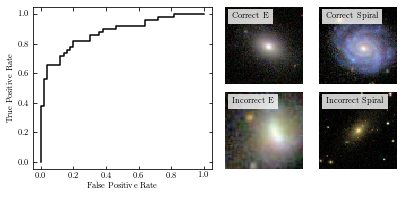

In [17]:
# AstroML - Convolution Neural Network example (Updated version)...

import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import roc_curve

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Conv2D

import random

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# The following added by tjp:
import numpy as np
from keras.models import model_from_json
from keras.models import model_from_yaml
from keras.optimizers import SGD
import imageio
%matplotlib inline

#pathsave="E_vs_S_deep/"
pathsave="TPurdy_data/"

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
plt.rcParams['axes.xmargin'] = 0.05
plt.rcParams['axes.ymargin'] = 0.05


def read_savefile(filename):
    '''Read npy save file containing images or labels of galaxies'''
    return np.load(filename)


def CNN(img_channels, img_rows, img_cols, verbose=False):
    '''Define CNN model for Nair and Abraham data'''

    # some hyperparamters you can chage
    dropoutpar = 0.5
    nb_dense = 64

    model = Sequential()
    model.add(Conv2D(32, (6, 6), padding='same',
                            input_shape=(img_rows, img_cols, img_channels)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (2, 2), padding='same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(nb_dense, activation='relu'))
    model.add(Dropout(dropoutpar))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    print("Compilation...")

    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    print("... done!")
    if verbose is True:
        print("Model Summary")
        print("===================")
        model.summary()
    return model


def train_CNN(X, Y, ntrain, nval, output="test", verbose=False):
    '''Train the CNN given a dataset and output model and weights'''

    # train params - hardcoded for simplicity
    batch_size = 30
    nb_epoch = 50
    data_augmentation = True  # if True the data will be augmented at every iteration

    ntrain = int(ntrain)
    nval = int(nval)
    ind = random.sample(range(0, ntrain+nval-1), ntrain+nval-1)
    X_train = X[ind[0:ntrain], :, :, :]
    X_val = X[ind[ntrain:ntrain+nval], :, :, :]
    Y_train = Y[ind[0:ntrain]]
    Y_val = Y[ind[ntrain:ntrain+nval]]

    # input image dimensions
    img_rows, img_cols = X_train.shape[1:3]
    img_channels = 3

    # Right shape for X
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols,
                              img_channels)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, img_channels)

    # Avoid more iterations once convergence
    patience_par = 10
    earlystopping = EarlyStopping(monitor='val_loss', patience=patience_par,
                                  verbose=0, mode='auto' )
    modelcheckpoint = ModelCheckpoint(output+"_best.hd5", monitor='val_loss',
                                      verbose=0, save_best_only=True)

    # Define CNN
    model = CNN(img_channels, img_rows, img_cols, verbose=True)

    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(X_train, Y_train,
                            batch_size=batch_size,
                            nb_epoch=nb_epoch,
                            validation_data=(X_val, Y_val),
                            shuffle=True, verbose=verbose,
                            callbacks=[earlystopping, modelcheckpoint])
    else:
        print('Using real-time data augmentation.')
        # this will do preprocessing and realtime data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=45,
            width_shift_range=0.05,
            height_shift_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=[0.75, 1.3])

        datagen.fit(X_train)
        
        print('samples_per_epoch=',X_train.shape[0])
        print('steps_per_epoch=',X_train.shape[0]/batch_size)
        
        history = model.fit_generator(
            datagen.flow(X_train, Y_train, batch_size=batch_size),
            samples_per_epoch=X_train.shape[0],
            nb_epoch=nb_epoch,
            validation_data=(X_val, Y_val),
            callbacks=[earlystopping, modelcheckpoint])

    print("Saving model...")
    # save weights
    model.save_weights(output+".weights", overwrite=True)


def apply_CNN(X, model_name):
    '''Apply a CNN to a data set'''
    # input image dimensions
    img_rows, img_cols = X.shape[1:3]
    img_channels = 3
    X = X.reshape(X.shape[0], img_rows, img_cols, img_channels)

    # load model & predict
    print("Loading weights", model_name)

    model = CNN(img_channels, img_rows, img_cols)
    model.load_weights(model_name+".weights")
    Y_pred = model.predict_proba(X)

    return Y_pred


def add_titlebox(ax, text):
    '''Add an embedded title into figure panel'''
    ax.text(.1, .85, text,
            horizontalalignment='left',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
    return ax


def plot_CNN_performance(pred, labels):
    '''Plot ROC curve and sample galaxies'''

    fig = plt.figure(figsize=(6, 3))
    fig.subplots_adjust(wspace=0.1, hspace=0.1,
                        left=0.1, right=0.95,
                        bottom=0.15, top=0.9)

    # define shape of figure
    gridsize = (2, 4)
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (0, 2))
    ax3 = plt.subplot2grid(gridsize, (0, 3))
    ax4 = plt.subplot2grid(gridsize, (1, 2))
    ax5 = plt.subplot2grid(gridsize, (1, 3))

    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(labels, pred)

    ax1.plot(fpr, tpr, color='black')
    ax1.set_xlabel(r'False Positive Rate')
    ax1.set_ylabel(r'True Positive Rate')

    # array of objects (good E, good S, bad E, bad S)
    goodE = np.where((pred[:, 0] < 0.5) & (labels == 0))
    goodS = np.where((pred[:, 0] > 0.5) & (labels == 1))
    badE = np.where((pred[:, 0] < 0.5) & (labels == 1))
    badS = np.where((pred[:, 0] > 0.4) & (labels == 0))
    
    goodEsize = len(goodE[0])
    goodSsize = len(goodS[0])
    badEsize = len(badE[0])
    badSsize = len(badS[0])
    print('Number of Good Ellipticals identified =',goodEsize)
    print('Number of Good Spirals identified     =',goodSsize)
    print('Number of Bad Ellipticals identified  =',badEsize)
    print('Number of Bad Spirals identified      =',badSsize)

    # Plot one of the correctly identified Ellipticals (if any):
    if (goodEsize > 0): ax2.imshow(D[pred_index + goodE[0][goodEsize-1]])
    add_titlebox(ax2, "Correct E")
    ax2.axis('off')

    # Plot one of the correctly identified Spirals (if any):
    if (goodSsize > 0): ax3.imshow(D[pred_index + goodS[0][goodSsize-1]])
    add_titlebox(ax3, "Correct Spiral")
    ax3.axis('off')

    # Plot one of the incorrectly identified Ellipticals (if any):
    if (badEsize > 0): ax4.imshow(D[pred_index + badE[0][badEsize-1]])
    add_titlebox(ax4, "Incorrect E")
    ax4.axis('off')

    # Plot one of the incorrectly identified Spirals (if any):
    if (badSsize > 0): ax5.imshow(D[pred_index + badS[0][badSsize-1]])
    add_titlebox(ax5, "Incorrect Spiral")
    ax5.axis('off')

    plt.show()

#######################################################################

n_objects = 1000
save_files = pathsave+"/SDSS{}".format(n_objects)

# Read SDSS images and labels
D = read_savefile(pathsave+"sdss_images_"+str(n_objects)+".npy")[0:n_objects]
Y = read_savefile(pathsave+"sdss_labels_"+str(n_objects)+".npy")[0:n_objects]

# Train network and output to disk (keep 10% of data for test set)
ntrain = D.shape[0] * 8 // 10.
nval = D.shape[0] // 10
npred = D.shape[0] - (ntrain + nval)  # test sample size;
pred_index = ntrain + nval            # test sample start index;

# Normalize images
mu = np.amax(D, axis=(1, 2))
for i in range(0, mu.shape[0]):
    D[i, :, :, 0] = D[i, :, :, 0] / mu[i, 0]
    D[i, :, :, 1] = D[i, :, :, 1] / mu[i, 1]
    D[i, :, :, 2] = D[i, :, :, 2] / mu[i, 2]

# change order so that we do not use always the same objects to train/test
D, Y, = shuffle(D, Y, random_state=0)

my_file = Path(save_files + ".weights")

pred_index = int(pred_index)
npred = int(npred)

if my_file.is_file():
    print("Reading Previous Training Model Parameters")
    print("====================")
    Y_pred = apply_CNN(D[pred_index:pred_index + npred, :, :, :], save_files)
    Y_test=Y[pred_index:pred_index + npred]
else:
    print("Training Model")
    print("====================")
    model_name = train_CNN(D, Y, ntrain, nval, output=save_files)
    Y_pred = apply_CNN(D[pred_index:pred_index + npred, :, :, :], save_files)
    Y_test = Y[pred_index:pred_index + npred]

Y_pred_class = Y_pred * 0
Y_pred_class[Y_pred > 0.5] = 1
print("Global Accuracy:", accuracy_score(Y_test, Y_pred_class))


plot_CNN_performance(Y_pred, Y_test)

## AstroML CNN Summary:
Below are the final resultant plot of True versus False Positive learning rates. This particular run of 1000 images shows a summary of the performance. The "Global Accuracy" on this "learned" training set shows ~80%.

Global Accuracy: 0.79
Number of Good Ellipticals identified = 43
Number of Good Spirals identified     = 36
Number of Bad Ellipticals identified  = 14
Number of Bad Spirals identified      = 10


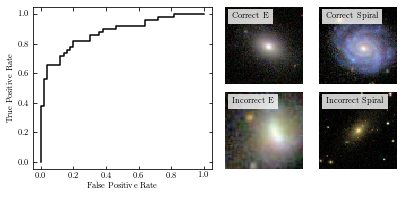

In [20]:
# Determine Global Accuracy:
Y_pred_class = Y_pred * 0
Y_pred_class[Y_pred > 0.5] = 1
print("Global Accuracy:", accuracy_score(Y_test, Y_pred_class))
print("=====================")

# Plot the True vs. False Positive Learning Rates:
plot_CNN_performance(Y_pred, Y_test)

# Final Research Project: Solar Feature Detection
- The Convolutional Neural Network (CNN) has four stages for learning upon images:
  - Input Image stage
  - Convolution Layer
  - Max-pooling
  - Fully Connected Neural Network Layer
- Original goal was to create a set of cropped images, from GONG H-Alpha Fits files, to feed into the Input Image stage.
  - Below are code snippets showing how to crop the GONG H-alpha image, in this case, centered on a Flare region from 2014

<class 'numpy.ndarray'>
(2048, 2048)
Filename: TPurdy_data/20141025170314Mh.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    159   (2048, 2048)   int16   

DATE =  2014-10-25T17:03:35


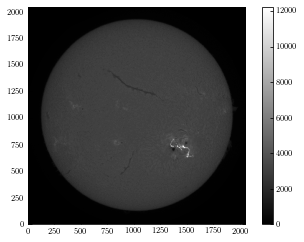

In [23]:
# Display a fits (regular or compressed) image:

from astropy.utils.data import download_file
from astropy.io import fits
import matplotlib.pyplot as plt 


image_file = 'TPurdy_data/20141025170314Mh.fits.fz'
image_header = fits.open(image_file)

image_data = fits.getdata(image_file)

print(type(image_data))
print(image_data.shape)

# Display Header block info:
image_header.info()

# Flip image about the horizonal:
#image_data = image_data.T

# Display compressed image header data:
#print(image_header[1].header)
print('\nDATE = ',image_header[1].header['DATE'])

# Plot the image:
plt.imshow(image_data, origin='lower', cmap='gray')
plt.colorbar()


SITE: ML 
DATE: 2014-10-25T17:03:35 
IMTYPE: H-ALPHA 
Max: 12253 
Min: 887 
Mean: 3501.6618367346937 
StdDev: 781.3202097579572
Filename =  TPurdy_data/20141025170314Mh.fits.fz


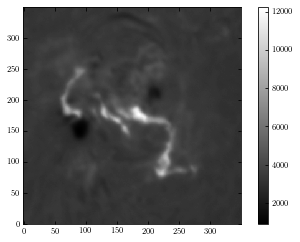

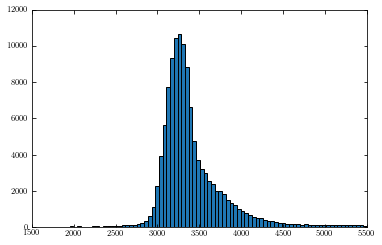

Peak Flare Value =  12253


In [28]:
# Display a crop of image around flare region:

import numpy as np 
import matplotlib.pyplot as plt 
from astropy.nddata import Cutout2D
from astropy import units
from astropy.io import fits
import glob
import math

data_set = {}

#file = 'ML/20141025170314Mh.fits.fz'
# going for the first file
img_header = fits.open(image_file)
img_data = fits.getdata(image_file)
    
# We're going to measure the center of the image, 100x100
#crop_center = ((img_data.shape[0] / 2), (img_data.shape[1] / 2))
#crop_size = units.Quantity((100,100), units.pixel)

# Flare region on fits.fz files:
crop_center = (1450, 725)
crop_size = units.Quantity((350,350), units.pixel)

# What I want to do:
# Open the header and image data
# create the file object with header info and data:
#   IMTYPE
#   SITE
#   DATE
#   img_data.shape <- to verify the proper geometry
#   CROP(data)
#   min, max, mean, std_dev

# Create the crop:
img_crop = Cutout2D(img_data, crop_center, crop_size)

# Write the header and data into a sample dictionary:
img_sample = { 'IMTYPE' : img_header[1].header['IMTYPE'],
               'ff_geometry' : img_data.shape,
               'crop_geometry' : img_crop.shape,
               'SITE' : img_header[1].header['SITE'],
               'DATE' : img_header[1].header['DATE'],
               'min' : np.min(img_crop.data),
               'max' : np.max(img_crop.data),
               'mean' : np.mean(img_crop.data),
               'std_dev' : np.std(img_crop.data),
               'data' : img_crop.data
              }

# Debug filenames...
#print('file.split =', file.split('\\')[1])

# Join image to the main data_set, keyed off file name:
data_set[image_file.split('/')[1]] = img_sample

print('\nSITE:', img_sample['SITE'], '\nDATE:', img_sample['DATE'], '\nIMTYPE:', img_sample['IMTYPE'], '\nMax:', img_sample['max'], '\nMin:', img_sample['min'], '\nMean:', img_sample['mean'], '\nStdDev:', img_sample['std_dev'])
print('Filename = ', image_file)

plt.imshow(data_set[image_file.split('/')[1]]['data'], origin='lower', cmap='gray')
plt.colorbar()
plt.show()

############
# Histogram:
NBINS = 256
xmin = 1500
xmax = 5500
ymin = 0
ymax = 12000

plt.hist(img_crop.data.flatten(), NBINS)
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.show()

print('===============================')
print('Peak Flare Value = ', (img_sample['max']))


# Project Summary
This was as far as I have gotten for Solar Feature Detection due, in large part, to the amount of time spent in trying to get an operational version of the AstroML example CNN program. During this course, this was my first attempt at using Python and Jupyter Notebook for software development (I'm old school Fortran and C/C++). I've gained an immense appreciation to the depth of libraries available under Jupyter and Anaconda development environments. This has opened a whole new avenue to me for image analysis, which I'll continue to find applicable in future endeavors.